In [1]:
!pip install numpy pandas faiss-gpu sentence_transformers --quiet

     |████████████████████████████████| 89.7 MB 9.1 kB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 2.9 MB 75.3 MB/s 
     |████████████████████████████████| 3.3 MB 63.4 MB/s 
     |████████████████████████████████| 1.2 MB 58.8 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 63.5 MB/s 
     |████████████████████████████████| 596 kB 74.4 MB/s 


In [2]:
data_folder = '/content/drive/MyDrive/ML-DL-DS/data/'

In [3]:
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import faiss
import torch
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cdist as scipy_cdist
import matplotlib.pyplot as plt


np.random.seed(0)  # for reproducibility

In [4]:
# wikipedia movie plots with summarization dataset (max 128 tokens): https://www.kaggle.com/gabrieltardochi/wikipedia-movie-plots-with-plot-summaries
# original wikipedia movie plots dataset (no summarization): https://www.kaggle.com/jrobischon/wikipedia-movie-plots
movies = pd.read_csv(data_folder + 'wiki_movie_plots_deduped_with_summaries.csv', usecols=['Title', 'PlotSummary'])
movies.drop_duplicates(subset='PlotSummary', inplace=True)
movies.reset_index(drop=True, inplace=True)

print(f"Plots of {len(movies.index)} movies!")

Plots of 33869 movies!


In [5]:
pd.set_option("max_colwidth", 1500)
movies[movies.Title == "Harry Potter and the Sorcerer's Stone"].iloc[0].PlotSummary

'Harry Potter is the orphaned son of two wizards who met their demise at the hands of Lord Voldemort, a malevolent, all-powerful wizard, by a Killing Curse. Harry is the only survivor in the chaos leading to his fame in the wizarding world as "The Boy Who Lived" Harry and his friends discover a giant three-headed dog named Fluffy guarding the Philosopher\'s Stone, an item that can grant its owner immortality.'

In [6]:
pd.set_option("max_colwidth", 50)

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'  # use GPU if available
encoder = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=torch_device)
plot_embeddings = encoder.encode(movies.PlotSummary.tolist(), device=torch_device)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
print(f"Plots are encoded as {plot_embeddings[0].size} dimensions vectors.")

Plots are encoded as 384 dimensions vectors.


In [8]:
selected_movies_idx = movies[movies.Title.str.contains("Toy Story|Despicable Me", regex=True)].index
similarities = 1 - scipy_cdist(plot_embeddings[selected_movies_idx], plot_embeddings[selected_movies_idx], 'cosine')
similarities = np.around(similarities, decimals=2)

cos_sims_df = pd.DataFrame(data=similarities,
                       columns=movies.Title.loc[selected_movies_idx].tolist(),
                       index=movies.Title.loc[selected_movies_idx].tolist())
cos_sims_df.sort_index(axis=1, inplace=True)  # sorting cols alphabetically
cos_sims_df.sort_index(axis=0, inplace=True)  # sorting rows alphabetically

cos_sims_df

,Despicable Me,Despicable Me 2,Despicable Me 3,Toy Story,Toy Story 2,Toy Story 3
Despicable Me,1.00,0.76,0.69,0.19,0.19,0.21
Despicable Me 2,0.76,1.00,0.69,0.22,0.29,0.27
Despicable Me 3,0.69,0.69,1.00,0.28,0.22,0.24
Toy Story,0.19,0.22,0.28,1.00,0.76,0.77
Toy Story 2,0.19,0.29,0.22,0.76,1.00,0.83
Toy Story 3,0.21,0.27,0.24,0.77,0.83,1.00


In [9]:
# getting the most similar movie for Godzilla vs. Kong (2021 movie, not in the Dataset)
godz_vs_kong_plot = """Five years after Godzilla defeated King Ghidorah, Kong is monitored by Monarch within a giant dome on Skull Island. Kong is visited by Jia, the last Iwi native and Kong expert Ilene Andrews' adopted daughter, who is deaf and communicates with Kong via sign language. Bernie Hayes, an employee of Apex Cybernetics and host of a Titan conspiracy theory podcast, extracts data suggesting sinister activities at a Pensacola facility. However, Godzilla suddenly attacks the facility; during the rampage, Bernie stumbles on a massive device. Madison Russell, a fan of Bernie's podcast, enlists her friend Josh to investigate Godzilla's attacks. Apex CEO Walter Simmons recruits Nathan Lind, former Monarch scientist and Hollow Earth theorist, to guide a search for a power source into the Hollow Earth, the homeworld of the Titans. Nathan is initially hesitant as his brother died in an expedition to the Hollow Earth due to a strong reverse-gravitational effect. He agrees after Walter reveals that Apex has developed HEAVs, specialized crafts able to withstand the pressure exerted by the gravity field."""

godz_vs_kong_embeddings = encoder.encode([godz_vs_kong_plot], device=torch_device)

start = timer()

similarities = 1 - scipy_cdist(godz_vs_kong_embeddings, plot_embeddings, 'cosine')
similarities = np.around(similarities, decimals=2)

end = timer()
print(f"Finished in {(end - start):.4f} seconds.")

best_sim_idx = np.argmax(similarities[0])  # index of the highest cosine similarity
most_similar_title = movies.loc[best_sim_idx].Title
most_similar_plot = movies.loc[best_sim_idx].PlotSummary
most_similar_title_sim = similarities[0].max()
print(f'Most similar movie given "Godzilla vs. Kong" plot: "{most_similar_title}" ({most_similar_title_sim} cosine similarity score).')
print(f'"{most_similar_plot}"')

Finished in 0.0507 seconds.
Most similar movie given "Godzilla vs. Kong" plot: "Godzilla vs. Destoroyah" (0.72 cosine similarity score).
"Miki Saegusa of the United Nations Godzilla Countermeasures Center (UNGCC) travels to check on Godzilla and its adopted child, but finds the entire island destroyed. Godzilla appears in Hong Kong, covered in glowing lava-like rashes, and goes on a rampage. The Japan Self Defense Forces deploys a flying combat vehicle outfitted with anti-nuclear cold weapons, the Super-X III, in an effort to reverse Godzilla's self-destruction. Meanwhile, scientists discover that Dr. Serizawa's Oxygen Destroyer, which was used against the original Godzilla in 1954, has awoken and mutated a colony"


In [10]:
# creating the cosine similarity matrix for our dataset using scipy.spatial.distance.cdist,
# so that we can get the most similar plot for each movie
start = timer()

similarities = 1 - scipy_cdist(plot_embeddings, plot_embeddings, 'cosine')
similarities = np.around(similarities, decimals=2)

end = timer()
print(f"Finished in {(end - start):.4f} seconds.")  # 7 minutes, RAM peak consumption over 12GB

Finished in 381.4790 seconds.


In [11]:
similarities.shape  # N x N matrix, where N = number of movies

(33869, 33869)

In [12]:
# faiss dummy example

dim = 2  # dimension of vectors

a = [.1, .2]
b = [.055, .1]

search_query = np.array([a]).astype(np.float32) 
database = np.array([b]).astype(np.float32)

# with L2 normalized vectors, the inner product becomes cosine similarity
faiss.normalize_L2(database)  # l2 normalization (in place)
index = faiss.IndexFlatIP(dim)  # method: exact search for inner product
index.add(database)

# searching
faiss.normalize_L2(search_query)  # l2 normalization (in place)
faiss_cos_sim, k_nearest_indexes = index.search(search_query, k=1)

# using scipy cdist cosine distance calculator for comparison 
scipy_cdist_cos_sim = 1 - scipy_cdist([a], [b], 'cosine')  # cosine similarity = 1 - cosine distance

In [13]:
v = np.array([1, -1, 2])
normalized_v = v / np.sqrt(np.sum(v**2))
print(f"l2 normalized v = {normalized_v}\nSum of the squares = {np.square(normalized_v).sum()}")

l2 normalized v = [ 0.40824829 -0.40824829  0.81649658]
Sum of the squares = 1.0000000000000002


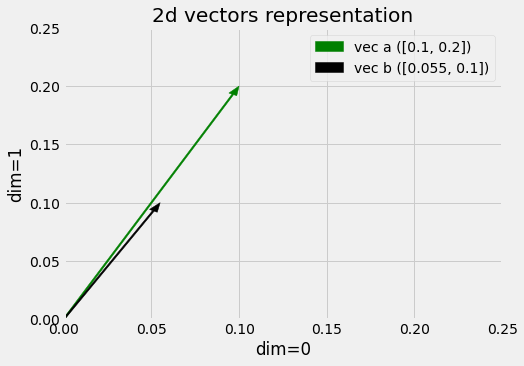

In [14]:
plt.style.use('fivethirtyeight')

f = plt.figure(figsize=(7,5))
plt.xlim([0, 0.25])
plt.ylim([0, 0.25])

arrow_a = plt.arrow(
    0, 0, a[0], a[1], color='g', width=0.001,
    head_length=0.008, head_width=0.005, length_includes_head=True
)
arrow_b = plt.arrow(
    0, 0, b[0], b[1], color='k', width=0.001,
    head_length=0.008, head_width=0.005, length_includes_head=True
)

plt.legend([arrow_a, arrow_b], [f'vec a ({a})', f'vec b ({b})'])
plt.xlabel('dim=0')
plt.ylabel('dim=1')

plt.title('2d vectors representation')
plt.show()

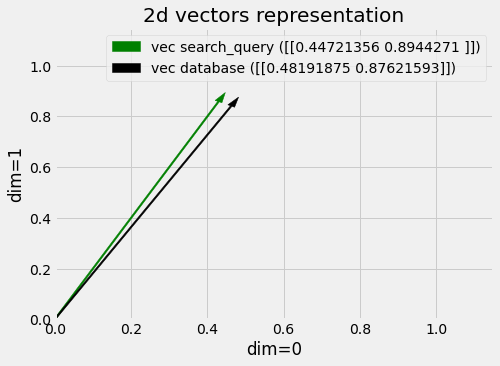

In [15]:
plt.style.use('fivethirtyeight')

f = plt.figure(figsize=(7,5))
plt.xlim([0, 1.15])
plt.ylim([0, 1.15])

arrow_search_query = plt.arrow(
    0, 0, search_query[0][0], search_query[0][1], color='g', width=0.0045,
    head_length=0.04, head_width=0.02, length_includes_head=True
)
arrow_database = plt.arrow(
    0, 0, database[0][0], database[0][1], color='k', width=0.0045,
    head_length=0.04, head_width=0.02, length_includes_head=True
)

plt.legend([arrow_search_query, arrow_database], [f'vec search_query ({search_query})',
                                                  f'vec database ({database})'])
plt.xlabel('dim=0')
plt.ylabel('dim=1')

plt.title('2d vectors representation')
plt.show()

In [16]:
print(f"FAISS cosine similarity: {float(faiss_cos_sim[0]):.4f}, Scipy Cdist cosine similarity: {float(scipy_cdist_cos_sim[0]):.4f}")

FAISS cosine similarity: 0.9992, Scipy Cdist cosine similarity: 0.9992


In [17]:
# creating FAISS index (no GPU)
dim = 384  # vector dimension

db_vectors = plot_embeddings.copy().astype(np.float32)
db_ids = movies.index.values.astype(np.int64)

faiss.normalize_L2(db_vectors)
index = faiss.IndexFlatIP(dim)
index = faiss.IndexIDMap(index)  # mapping df index as id
index.add_with_ids(db_vectors, db_ids)

# get the most similar plot for each movie, this time using FAISS index
# search for top2 similar plots, since the top1 should be the same movie
k_nearest = 2  

search_query = plot_embeddings.copy().astype(np.float32)

start = timer()

faiss.normalize_L2(search_query)

similarities, similarities_ids = index.search(search_query, k=k_nearest)
similarities = np.around(np.clip(similarities, 0, 1), decimals=4)

end = timer()
print(f"Finished in {(end - start):.4f} seconds.")  # 14 seconds, RAM peak consumption under 3GB

Finished in 12.4220 seconds.


In [18]:
# get the most similar plot for each movie, this time using FAISS index
# search for top2 similar plots, since the top1 should be the same movie
k_nearest = 2  

search_query = plot_embeddings.copy().astype(np.float32)

start = timer()

faiss.normalize_L2(search_query)

similarities, similarities_ids = index.search(search_query, k=k_nearest)
similarities = np.around(np.clip(similarities, 0, 1), decimals=4)

end = timer()
print(f"Finished in {(end - start):.4f} seconds.")  # 14 seconds, RAM peak consumption under 3GB

Finished in 12.3006 seconds.


In [19]:
# making it faster! (GPU)
gpu_res = faiss.StandardGpuResources()  # use a single GPU
gpu_index = faiss.index_cpu_to_gpu(gpu_res, 0, index)  # moving our index to GPU

# search for top2 similar plots, since the top1 should be the same movie
k_nearest = 2  

search_query = plot_embeddings.copy().astype(np.float32)

start = timer()

faiss.normalize_L2(search_query)

similarities, similarities_ids = gpu_index.search(search_query, k=k_nearest)
similarities = np.around(np.clip(similarities, 0, 1), decimals=4)

end = timer()
print(f"Finished in {(end - start):.4f} seconds.")  # 0.1 seconds, RAM peak consumption under 3GB

Finished in 0.1423 seconds.


In [20]:
similarities  # cosine similarity of the most similar movie, for each movie plot

array([[1.    , 0.5498],
       [1.    , 0.505 ],
       [1.    , 0.5593],
       ...,
       [1.    , 0.5792],
       [1.    , 0.5504],
       [1.    , 0.6542]], dtype=float32)

In [21]:
similarities_ids  # id of the most similar movie, for each movie plot

array([[    0,  6832],
       [    1, 14278],
       [    2, 12761],
       ...,
       [33866, 30045],
       [33867,  2183],
       [33868, 33818]])

In [22]:
highest_val_idx = np.argmax([sum(sim_vec) for sim_vec in similarities])
similarities[highest_val_idx]  # highest similarity pair here

array([1.    , 0.9978], dtype=float32)

In [23]:
similarities_ids[highest_val_idx]  # highest similarity pair indexes on the dataframe

array([15803, 20865])

In [25]:
pd.set_option("max_colwidth", 1500)
movies.loc[similarities_ids[highest_val_idx]]

,Title,PlotSummary
15803,Nanny McPhee Returns,"Isabel Green is driven to her wits end by her hectic life on a farm during World War II. Her husband is away at war, while her children's two wealthy cousins, Cyril and Celia, also then come to live with them. Isabel's brother-in-law, Phil, has gambled away his half of the farm, and is being chased by two hired-assassin women under casino owner Mrs. Biggles."
20865,Nanny McPhee and the Big Bang,"Isabel Green is driven to her wits end by her hectic life on a farm during World War II. Her husband is away at war, while her children's two wealthy cousins, Cyril and Celia, also then come to live with them. Isabel's brother-in-law, Phil, has gambled away his half of the farm, and is being chased by two hired female assassin's working for casino owner Mrs. Biggles."
